# Paramount Restaurant Simulation using SimPy

###  Bus 36109 "Advanced Decision Modeling with Python", Don Eisenstein
Don Eisenstein &copy; Copyright 2020, University of Chicago 

---

In this initial Paramount Simulation we assume the following.  All times are deterministic in this initial simulation, that is, no variation.
- Customers arrive with `MEAN_TIME_BETWEEN_ARRIVALS` seconds between them
- They then queue for one of `NUM_COOKS`
- It takes one cook `MEAN_COOK_TIME_DURATION` seconds to prepare their food order
- They then queue for one of `NUM_SEATS`
- It takes one customer `MEAN_EATING_DURATION` seconds to complete their meal 

We are also assuming simple communal seating, with no concept of eating with a party that must be seated at their own table.

In [31]:
NUM_CUSTOMERS = 10
MEAN_TIME_BETWEEN_ARRIVALS = 200
MEAN_COOK_TIME_DURATION = 190
MEAN_EATING_DURATION = 200
NUM_COOKS = 4
NUM_SEATS = 25

In [36]:
import simpy 
import numpy as np
import matplotlib.pyplot as plt
import pprint
from pprint import pprint
from ppretty import ppretty

In [47]:
def generate_customers(env, number):
    customer_objects_list = []
    arrival_time = 0
    
    for i in range(number):
        customer_name = f'Customer {i}'      # create a job name string 
        arrival_time = arrival_time + MEAN_TIME_BETWEEN_ARRIVALS 
        cook_duration =  MEAN_COOK_TIME_DURATION
        eating_duration = MEAN_EATING_DURATION 

        customer = Customer(env, customer_name, arrival_time, cook_duration, eating_duration)
        customer_objects_list.append(customer)
    return customer_objects_list 

In [48]:
env = simpy.Environment()
cook_resource = simpy.Resource(env, capacity=NUM_COOKS)
seat_resource = simpy.Resource(env, capacity=NUM_SEATS)

In [49]:
class Customer(object):
    def __init__(self, env, name, arrival_time, cook_duration, eating_duration):
        # Store the simulation environment
        self.env = env
        self.name = name
        self.arrival_time = arrival_time
        # Note our convention:  "time" vs "duration"
        # "time" we use to denote simulation wall clock time
        # "duration" we use to denote how long something will take 
        self.begin_cook_service_time = None
        self.cook_duration = cook_duration
        self.enter_seating_queue_time = None
        self.begin_eating_time = None
        self.eating_duration = eating_duration
        self.departure_time = None
        
        print(f'Create Customer {self.name}')
        # Start the process everytime an instance is created.
        env.process(self.process_thru_restaurant())
        
    def process_thru_restaurant(self):
        yield self.env.timeout(self.arrival_time)
        print('Customer arrives at %d' % self.env.now)
        request = cook_resource.request()  # request a cook
        yield request 

        print('Customer arrives to cook at %d' % self.env.now)
        self.begin_cook_service_time = env.now
        yield env.timeout(self.cook_duration)  # cook food 
        cook_resource.release(request)      # release cook 

        self.enter_seating_queue_time = env.now
        print('Customer arrives to seating queue at %d' % self.env.now)
        request = seat_resource.request()  # request a seat 
        yield request 
        
        self.begin_eating_time = env.now
        yield env.timeout(self.eating_duration)  # eat food 
        seat_resource.release(request)      # release seat 
        
        # Customer completes service 
        print('Service completed at %d' % self.env.now)
        self.departure_time = env.now

In [50]:
customer_list = generate_customers(env,NUM_CUSTOMERS)

Create Customer Customer 0
Create Customer Customer 1


In [51]:
# Yes, this is a bit convoluted, but it is one way to show our objects formatted nicely with all their attributes
# Don't ask me exactly why this works....!
print(ppretty(customers, seq_length=10))

[
    __main__.Customer(
        arrival_time = 200, 
        begin_cook_service_time = None, 
        begin_eating_time = None, 
        cook_duration = 190, 
        departure_time = None, 
        eating_duration = 200, 
        enter_seating_queue_time = None, 
        env = simpy.core.Environment(), 
        name = 'Customer 0'
    ), 
    __main__.Customer(
        arrival_time = 400, 
        begin_cook_service_time = None, 
        begin_eating_time = None, 
        cook_duration = 190, 
        departure_time = None, 
        eating_duration = 200, 
        enter_seating_queue_time = None, 
        env = simpy.core.Environment(), 
        name = 'Customer 1'
    )
]


In [52]:
env.run()

Customer arrives at 200
Customer arrives to cook at 200
Customer arrives to seating queue at 390
Customer arrives at 400
Customer arrives to cook at 400
Service completed at 590
Customer arrives to seating queue at 590
Service completed at 790


### Compute average time a job spends in the system

In [53]:
# loop through all the jobs
system_times = []
for customer in customer_list:
    system_times.append(customer.departure_time-customer.arrival_time)
print(f'average time in system is {np.mean(system_times)}')

average time in system is 390.0


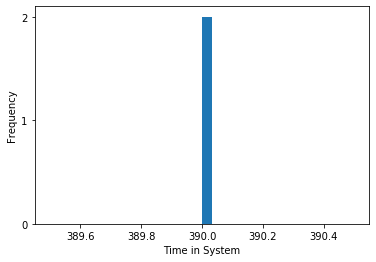

In [54]:
# Tinker with number of bins, until it looks right
plt.hist(system_times,bins=30)
# you can customize the exact tick marks on an axis
plt.yticks(range(0,3))
plt.ylabel('Frequency');
plt.xlabel('Time in System');

# Homework/In-class work

1. Suppose customers arrive to your queue with an exponentially distrubuted time between arrivals of 30 seconds and are served by one of two *parallel* servers, each server can, on average serve a customer in 50 seconds, with the service time exponentially distributed.

1. Now, return back to one server, but add a second server in *series*.  That is, each job first is serviced by a single Server 1, and then by a single Server 2.  Assume to exponential arrivals with a mean time between arrivals of 200 and exponential service time with mean of 190 for each server.  
   - Compute the average system time
   - Plot a histogram of total time in system


1. Of course, we may want to use other distributions in a simulation.  Write functions for the exponential and these other distributions,  `normal`, `triangular`,  and `uniform`, explore the `numpy` documentation:  https://docs.scipy.org/doc/numpy-1.14.0/reference/routines.random.html

   - remember, make sure your functions return only positive values for our purposes.
   - try out each of your functions to make sure they work as expected
   

1.  Consider the Paramount restaurant.  
    - Model a busy input stream of customers in the morning rush ...
    - Consider 4 cooks that ...
    - Consider community seating with XX seats and the dining experience ...
    